In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image

def load_dib_image(filepath):
    #Rename the file extension from .DIB to .BMP in memory
    with open(filepath, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
        return np.array(img)


## check the images
### DIB are loaded with Pillow and converted to array 
### Note that png are read differently with cv2.imread (y axis is flipped. So used np.flipud())

(512, 512, 3)


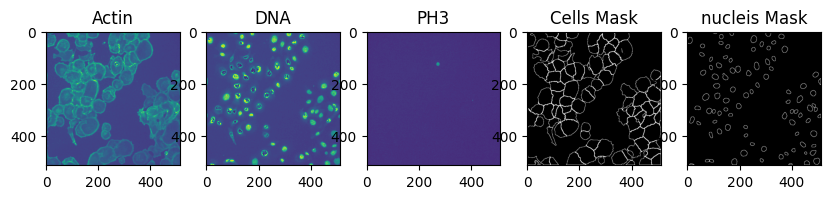

In [12]:
base_dir = '/Users/yuqi/Downloads/BBBC018_v1_images/'
outline_dir = '/Users/yuqi/Downloads/BBBC018_v1_outlines/'
specimen_id = '00733'

# Load three contrast images
actin_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-actin.DIB'))
dna_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-DNA.DIB'))
ph3_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-PH3.DIB'))
print(actin_img.shape)
# Load outline mask (as label for now)
cell_mask = cv2.imread(os.path.join(outline_dir, f'{specimen_id}-cells.png'), cv2.IMREAD_GRAYSCALE)
nuclei_mask = cv2.imread(os.path.join(outline_dir,f'{specimen_id}-nuclei.png'))
# Stack contrasts into a multi-channel image
img_stack = np.stack([actin_img[:,:,0], dna_img[:,:,0], ph3_img[:,:,0]], axis=-1)

N= 5
# Show example
plt.figure(figsize=(10,N))
plt.subplot(1,N,1); plt.imshow(actin_img[:,:,1]); plt.title('Actin')
plt.subplot(1,N,2); plt.imshow(dna_img[:,:,1]); plt.title('DNA')
plt.subplot(1,N,3); plt.imshow(ph3_img[:,:,1]); plt.title('PH3')
plt.subplot(1,N,4); plt.imshow(np.flipud(cell_mask), cmap='gray'); plt.title('Cells Mask')
plt.subplot(1,N,5); plt.imshow(np.flipud(nuclei_mask)); plt.title('nucleis Mask')

plt.show()

### Basic DL env

Augment image and mask by 3 times. 

55 images -> 220. Through API albumentation (fast and even provides elastic transforms)

In [50]:
import albumentations as A
import numpy as np
import cv2
import os

def read_train_data(specimen_id,base_dir,outline_dir):
    
    actin_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-actin.DIB'))
    #dna_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-DNA.DIB'))
    #ph3_img = load_dib_image(os.path.join(base_dir, f'{specimen_id}-PH3.DIB'))
    img_stack = actin_img[:,:,1]

    # Load outline mask (as label for now)
    cell_mask = cv2.imread(os.path.join(outline_dir, f'{specimen_id}-cells.png'), cv2.IMREAD_GRAYSCALE)
    if cell_mask is None:
        return None,None

    
    img_stack = cv2.resize(img_stack, (256, 256))
    cell_mask = cv2.resize(cell_mask, (256, 256))   
    cell_mask = (cell_mask > 0).astype(np.float32) #do it after resizing because resizing changes the value. 
    cell_mask = np.flipud(cell_mask)
    return img_stack,cell_mask
    
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #A.GaussianBlur(p=0.3),
    #A.RandomBrightnessContrast(p=0.5),
    #A.GaussNoise(p=0)
])

def augment_and_expand_dataset(specimen_ids, base_dir, outline_dir, augmentations_per_sample=3):
    x = []
    y = []

    for specimen in specimen_ids:
        # Load the original data
        img, mask = read_train_data(specimen, base_dir, outline_dir)

        if img is None or mask is None:
            continue
        
        #Normalize so that model is more stable. 
        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        #mask = mask/255.0, already binarized: cell_mask = (cell_mask > 0).astype(np.float32)
        # Add the original sample
        x.append(img/255.0)
        y.append(mask)
        #print(np.unique(mask))
        # Create augmented versions
        for _ in range(augmentations_per_sample):
            augmented = albumentations_transform(image=img, mask=mask)
            aug_img = augmented['image']
            aug_mask = augmented['mask']
            aug_mask = (aug_mask > 0.5).astype(np.float32)
            #print(np.unique(aug_mask))
            x.append(aug_img/255.0)
            y.append(aug_mask)

    x = np.array(x, dtype='float32')
    y = np.array(y, dtype='float32')

    return x, y

# Example usage:
base_dir = '/Users/yuqi/Downloads/BBBC018_v1_images/'
outline_dir = '/Users/yuqi/Downloads/BBBC018_v1_outlines/'

# Your existing sample IDs (55)
specimen_ids = [file.split('-')[0] for file in os.listdir(base_dir) if file.endswith('actin.DIB')]
#print(specimen_ids)
# Expand the dataset
x_aug, y_aug = augment_and_expand_dataset(specimen_ids, base_dir, outline_dir, augmentations_per_sample=3)
#x_aug = np.expand_dims(x_aug,axis=-1)
print("Expanded dataset size:", x_aug.shape[0])  # Should be around 200+
x_train,x_test,y_train,  y_test = train_test_split(x_aug,y_aug,test_size=0.2,random_state = 42)
print(f"x_train shape: {x_train.shape}, dtype: {x_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"x_test shape: {x_test.shape}, dtype: {x_test.dtype}")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(type(x_train))
print(type(y_train))
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

/var/folders/tm/z749zy7x1673143rgv5s8tz40005dx/T/ipykernel_18995/2533286403.py:29: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
[ WARN:0@1826.776] global loadsave.cpp:268 findDecoder imread_('/Users/yuqi/Downloads/BBBC018_v1_outlines/10779-cells.png'): can't open/read file: check file path/integrity


Expanded dataset size: 220
x_train shape: (176, 256, 256, 1), dtype: float32
y_train shape: (176, 256, 256, 1), dtype: float32
x_test shape: (44, 256, 256, 1), dtype: float32
y_test shape: (44, 256, 256, 1), dtype: float32
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


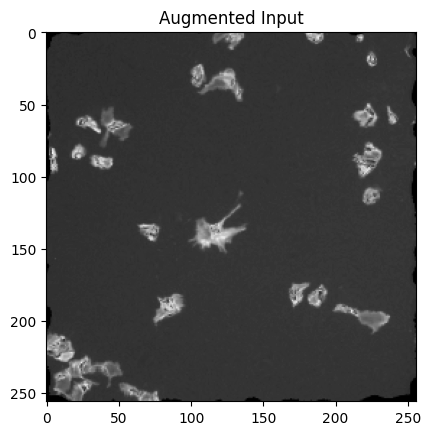

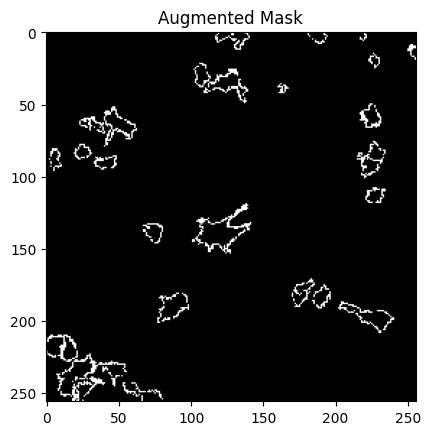

x_train min/max: 0.0/1.0
y_train unique values: [0. 1.]


In [51]:
import matplotlib.pyplot as plt

# Visualize some training data (after augmentation)
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title('Augmented Input')
plt.show()

# Visualize the corresponding mask
plt.imshow(y_train[0].squeeze(), cmap='gray')
plt.title('Augmented Mask')
plt.show()

print(f"x_train min/max: {x_train.min()}/{x_train.max()}")
print(f"y_train unique values: {np.unique(y_train)}")

In [52]:

def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b1)
    concat1 = concatenate([u1, c2])
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)

    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    concat2 = concatenate([u2, c1])
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model




In [53]:
import tensorflow.keras.backend as K
def custom_cosine_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Dot product
    dot_product = K.sum(y_true_f * y_pred_f)
    dot_product2 = K.sum((1-y_true_f) * y_pred_f)
    # L2 norms
    norm_true = K.sqrt(K.sum(K.square(y_true_f)))
    norm_pred = K.sqrt(K.sum(K.square(y_pred_f)))
    norm_inverse_true = K.sqrt(K.sum(K.square(1-y_true_f)))
    # Cosine similarity
    cosine_similarity = dot_product / (norm_true * norm_pred + K.epsilon())
    cosine_similarity2 = dot_product2 / (norm_inverse_true * norm_pred + K.epsilon())

    # Loss: 1 - cosine similarity
    loss = 1 - cosine_similarity + 0.5*cosine_similarity2
    
    return loss

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return loss
    
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

model = unet()
model.compile(optimizer='adam', loss=custom_cosine_loss, metrics=[dice_coefficient, iou_metric,'accuracy'])
#model.compile(optimizer = Adam(learning_rate = 1e-4),loss = "binary_crossentropy",metrics=['accuracy'])
#model.compile(optimizer = Adam(learning_rate = 1e-4),loss = custom_cosine_loss,metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 128, 128,  │      8,224 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,464 │ concatenate_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 256, 256,  │      2,064 │ conv2d_21[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      4,624 │ concatenate_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │         17 │ conv2d_22[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,689 (221.44 KB)

 Trainable params: 56,689 (221.44 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:

history = model.fit(x_train,y_train, epochs = 20,batch_size=8) 
#history = model.fit(x_train,y_train, epochs = 40,validation_data = (x_test,y_test), batch_size=8) 
# Evaluate on test set
loss, _,_,accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

# Predict on test set
y_pred = model.predict(x_test)



Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9146 - dice_coefficient: 0.2277 - iou_metric: 0.1288 - loss: 0.7353
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9151 - dice_coefficient: 0.2026 - iou_metric: 0.1139 - loss: 0.7456
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9194 - dice_coefficient: 0.1990 - iou_metric: 0.1111 - loss: 0.7238
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9223 - dice_coefficient: 0.1861 - iou_metric: 0.1028 - loss: 0.7267
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9181 - dice_coefficient: 0.2036 - iou_metric: 0.1139 - loss: 0.7239
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9188 - dice_coefficient: 0.1529 - iou_metric: 0.0831 - loss: 0.7167
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9157 - dice_coefficient: 0.1788 - iou_metric: 0.0983 - loss: 0.7130
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9192

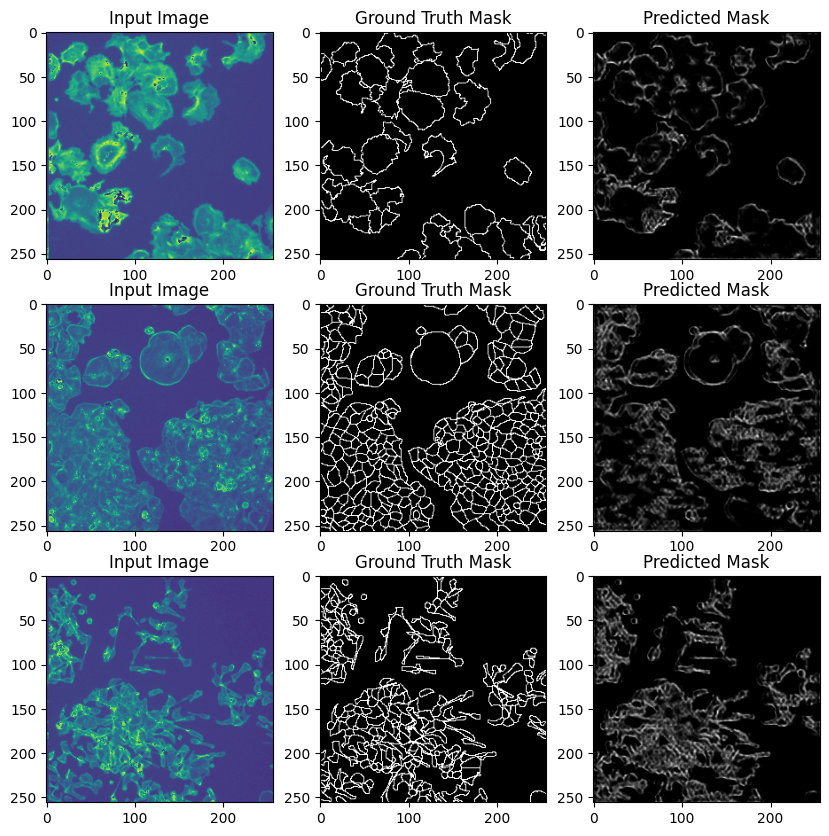

In [57]:
num_examples = 3
plt.figure(figsize=(10, 10))

for i in range(num_examples):
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(x_test[i])
    plt.title('Input Image')

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(y_pred[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
#plt.savefig('/Users/yuqi/Downloads/damn_image.png')
plt.show()

### What happened?
The mask is a contour (an outline, not a filled-in region), so the inside of the cell is zero, and only the boundary pixels are labeled as 1.

Class Imbalance:
The model sees mostly background, so it learns to predict background everywhere.The accuracy is still 90%!

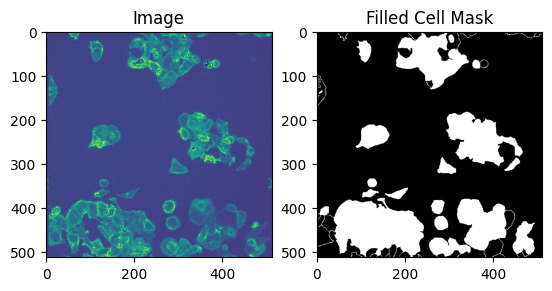

In [86]:
import matplotlib.pyplot as plt

sample_image, sample_mask = read_train_data(specimen_ids[0], base_dir, outline_dir)

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(sample_image.astype(np.float32))

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(sample_mask, cmap='gray')

#plt.show()

import cv2
import numpy as np

# Assuming you have a binary contour mask
contour_mask = sample_mask
contour_mask = (contour_mask > 0).astype(np.uint8)

# Find contours
contours, hierarchy = cv2.findContours(contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask
filled_mask = np.zeros_like(contour_mask)

# Fill the contours
cv2.drawContours(filled_mask, contours, -1, color=1, thickness=-1)  # Fill with 1s

# Now 'filled_mask' is the filled version
plt.imshow(filled_mask, cmap='gray')
plt.title("Filled Cell Mask")
plt.show()